In [1]:
!pip install Keras-Preprocessing

In [17]:
# import necessary libraries and packages
import pandas as pd
import numpy as np

import nltk, re, string
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\11356\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\11356\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\11356\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data Preprocessing

In [18]:
from sklearn.model_selection import train_test_split

lemma = WordNetLemmatizer()
stop = stopwords.words('english')

# helper function to clean the sentence input to make it suitable for ML models
def Text_clean(txt):
    txt = txt.lower()
    words = nltk.word_tokenize(txt)
    words = ' '.join([lemma.lemmatize(word) for word in words if word not in stop])
    words_joined = "".join(words)
    text = re.sub('[^a-z]',' ',words_joined) #remove symbols 
    return text  

df_train = pd.read_csv("finbank_data_train.csv")
# apply Text_clean to the text column in the table, and create a new column "text_clean"
df_train['text_clean'] = df_train['text'].apply(Text_clean)
sentences_train = df_train['text_clean'].values
y_train = df_train['label'].values

df_test = pd.read_csv("finbank_data_test.csv")
# apply Text_clean to the text column in the table, and create a new column "text_clean"
df_test['text_clean'] = df_test['text'].apply(Text_clean)
sentences_test = df_test['text_clean'].values
y_test = df_test['label'].values

df_val = pd.read_csv("finbank_data_val.csv")
# apply Text_clean to the text column in the table, and create a new column "text_clean"
df_val['text_clean'] = df_val['text'].apply(Text_clean)
sentences_val = df_val['text_clean'].values
y_val = df_val['label'].values

In [19]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# helper function for plotting history of the model training process
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)
X_val=tokenizer.texts_to_sequences(sentences_val)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit([['neutral'],['positive'],['negative']])

# transform Label of Train set to One Hot Encoding
temp=[]
for i in y_train:
    if i=='neutral':
        temp.append([0,1,0])
    if i=='positive':
        temp.append([1,0,0])
    if i=='negative':
        temp.append([0,0,1])
y_train=np.array(temp)
print(y_train)

# transform Label of Test set to One Hot Encoding
temp=[]
for i in y_test:
    if i=='neutral':
        temp.append([0,1,0])
    if i=='positive':
        temp.append([1,0,0])
    if i=='negative':
        temp.append([0,0,1])
y_test=np.array(temp)

# transform Label of Validation set to One Hot Encoding
temp=[]
for i in y_val:
    if i=='neutral':
        temp.append([0,1,0])
    if i=='positive':
        temp.append([1,0,0])
    if i=='negative':
        temp.append([0,0,1])
y_val=np.array(temp)


from keras_preprocessing.sequence import pad_sequences

maxlen = 100
embedding_dim = 50
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_val=pad_sequences(X_val, padding='post', maxlen=maxlen)
print(X_train)

[[1 0 0]
 [0 0 1]
 [0 1 0]
 ...
 [0 1 0]
 [1 0 0]
 [0 1 0]]
[[  82  604  391 ...    0    0    0]
 [   9  360  723 ...    0    0    0]
 [  52 3809 2131 ...    0    0    0]
 ...
 [  31  301    6 ...    0    0    0]
 [ 268 2215  641 ...    0    0    0]
 [ 332 3620 3621 ...    0    0    0]]


# Hyperparameters Tuning

We use grid search to find the optimal hyperparameters for our LSTM model.

In [6]:
!pip install scikeras

In [7]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential
from keras import layers
embedding_dim = 50
epochs = 20
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen,optimizer):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


5810


In [9]:
    param_grid = dict(num_filters=[32, 64, 128],
                      kernel_size=[3, 5, 7],
                      optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adam'],
                      vocab_size=[vocab_size],
                      epochs = [5, 7, 10],
                      batch_size=[32,64,128],
                      embedding_dim=[embedding_dim],
                      maxlen=[maxlen])
    model = KerasClassifier(build_fn=create_model,
                            verbose=False)
    grid =GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
    grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
    test_accuracy = grid.score(X_test, y_test)

    # Save and evaluate results
    display(grid_result)
    print(grid_result.best_score_,
            grid_result.best_params_,
            test_accuracy)

C:\Users\11356\AppData\Local\Temp\ipykernel_16012\2072276118.py:9: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model,


GridSearchCV(cv=2,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x00000219CFDBAB30>,
             param_grid={'batch_size': [32, 64, 128], 'embedding_dim': [50],
                         'epochs': [5, 7, 10], 'kernel_size': [3, 5, 7],
                         'maxlen': [100], 'num_filters': [32, 64, 128],
                         'optimizer': ['SGD', 'RMSprop', 'Adagrad', 'Adam'],
                         'vocab_size': [5810]})

0.8345807492733002 {'batch_size': 32, 'embedding_dim': 50, 'epochs': 7, 'kernel_size': 3, 'maxlen': 100, 'num_filters': 128, 'optimizer': 'Adam', 'vocab_size': 5810} 0.8852739930152893


In [15]:
def print_gridsearch_results(grid_result):
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
      print("%f (%f) with: %r" % (mean, stdev, param))
print_gridsearch_results(grid_result)
display(grid_result.cv_results_)

Best: 0.834581 using {'batch_size': 32, 'embedding_dim': 50, 'epochs': 7, 'kernel_size': 3, 'maxlen': 100, 'num_filters': 128, 'optimizer': 'Adam', 'vocab_size': 5810}
0.342393 (0.004781) with: {'batch_size': 32, 'embedding_dim': 50, 'epochs': 5, 'kernel_size': 3, 'maxlen': 100, 'num_filters': 32, 'optimizer': 'SGD', 'vocab_size': 5810}
0.756684 (0.014390) with: {'batch_size': 32, 'embedding_dim': 50, 'epochs': 5, 'kernel_size': 3, 'maxlen': 100, 'num_filters': 32, 'optimizer': 'RMSprop', 'vocab_size': 5810}
0.322704 (0.002927) with: {'batch_size': 32, 'embedding_dim': 50, 'epochs': 5, 'kernel_size': 3, 'maxlen': 100, 'num_filters': 32, 'optimizer': 'Adagrad', 'vocab_size': 5810}
0.805691 (0.005177) with: {'batch_size': 32, 'embedding_dim': 50, 'epochs': 5, 'kernel_size': 3, 'maxlen': 100, 'num_filters': 32, 'optimizer': 'Adam', 'vocab_size': 5810}
0.344748 (0.007136) with: {'batch_size': 32, 'embedding_dim': 50, 'epochs': 5, 'kernel_size': 3, 'maxlen': 100, 'num_filters': 64, 'optimiz

{'mean_fit_time': array([ 2.21901989,  2.14660788,  1.93119156,  2.64166844,  2.38647246,
         2.35195768,  2.70716131,  3.29777265,  3.3001045 ,  3.45442832,
         3.62569904,  5.6676352 ,  3.48318052,  2.93797874,  2.79382384,
         3.84385777,  3.08182502,  2.89140856,  2.80854225,  3.47102475,
         3.64742613,  3.58770835,  3.89341009,  4.80152297,  2.85000169,
         2.73365068,  2.74873221,  3.34954751,  3.25406778,  2.89456725,
         2.68771517,  3.42105317,  3.75058007,  4.20884216,  4.06874168,
         4.64222336,  3.56907284,  3.5601753 ,  3.24431515,  4.24417973,
         4.90052569,  3.7222842 ,  3.95298028,  3.86145139,  4.88656497,
         4.69171989,  4.55325544,  5.02661967,  3.48734486,  3.35485721,
         3.37402272,  3.80042946,  3.84311628,  3.57734799,  3.46935999,
         3.97170556,  4.20938957,  4.38912785,  4.25460434,  5.16990912,
         3.57552302,  3.51498926,  3.32758904,  4.08914769,  4.05527246,
         4.07491386,  3.44330823, 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           290500    
                                                                 
 conv1d (Conv1D)             (None, 98, 128)           19328     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 311,151
Trainable params: 311,151
Non-trainable params: 0
__________________________________________________

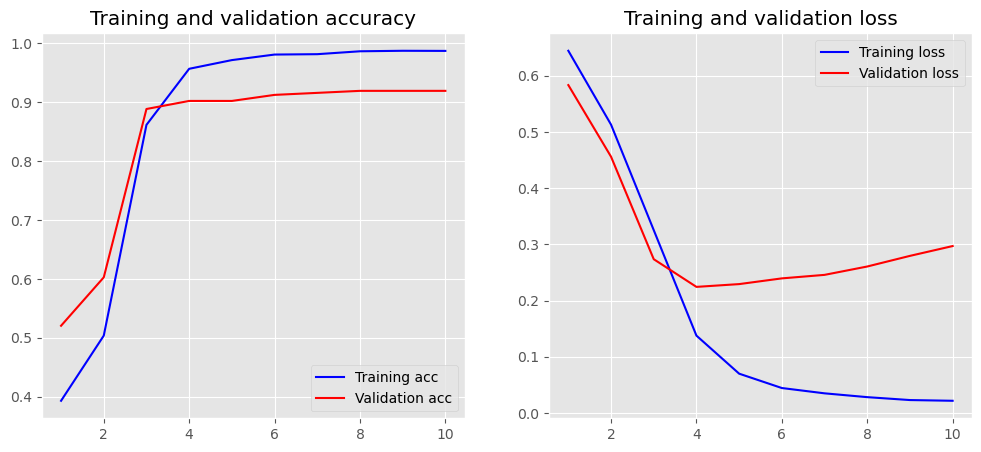

In [21]:
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session
clear_session()
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128,3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_val, y_val),
                    batch_size=32)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [23]:
df_news_Earnings = pd.read_csv("news_Earnings.csv")
df_news_Economic = pd.read_csv("news_Economic.csv")
df_news_StockMarket = pd.read_csv("news_StockMarket.csv")

df_news_Earnings['text_clean'] = df_news_Earnings['test'].apply(Text_clean)
df_news_Economic['text_clean'] = df_news_Economic['test'].apply(Text_clean)
df_news_StockMarket['text_clean'] = df_news_StockMarket['test'].apply(Text_clean)

df_news_Earnings_sentences = df_news_Earnings['text_clean'].values
df_news_Economic_sentences = df_news_Economic['text_clean'].values
df_news_StockMarket_sentences = df_news_StockMarket['text_clean'].values

X_news_Earnings = tokenizer.texts_to_sequences(df_news_Earnings_sentences)
X_news_Economic = tokenizer.texts_to_sequences(df_news_Economic_sentences)
X_news_StockMarket = tokenizer.texts_to_sequences(df_news_StockMarket_sentences)

X_news_Earnings = pad_sequences(X_news_Earnings, padding='post', maxlen=maxlen)
X_news_Economic = pad_sequences(X_news_Economic, padding='post', maxlen=maxlen)
X_news_StockMarket = pad_sequences(X_news_StockMarket, padding='post', maxlen=maxlen)

y_news_Earnings = model.predict(X_news_Earnings)
y_news_Economic = model.predict(X_news_Economic)
y_news_StockMarket = model.predict(X_news_StockMarket)
# convert softmax output to labels
temp=[]
for i in y_news_Earnings:
    temp.append(np.argmax(i))
y_news_Earnings=np.array(temp)

# convert softmax output to labels
temp=[]
for i in y_news_Economic:
    temp.append(np.argmax(i))
y_news_Economic=np.array(temp)

# convert softmax output to labels
temp=[]
for i in y_news_StockMarket:
    temp.append(np.argmax(i))
y_news_StockMarket=np.array(temp)
df_news_Earnings['test_result'] = y_news_Earnings
df_news_Economic['test_result'] = y_news_Economic
df_news_StockMarket['test_result'] = y_news_StockMarket

1/1 [==============================] - 0s 24ms/step


In [24]:
df_news_Economic

,test,label,text_clean,test_result
0,Tokyo Inflation Slows Ahead of BOJ Leadership ...,positive,tokyo inflation slows ahead boj leadership cha...,0
1,Fed Watchdog Launches Investigation Into SVB S...,neutral,fed watchdog launch investigation svb supervision,0
2,Fed Officials See More Work on Inflation Despi...,neutral,fed official see work inflation despite bank s...,1
3,Colombia Hikes Interest Rate to 24-Year High t...,neutral,colombia hike interest rate year high tame ...,1
4,"Australian Inflation Eases, Bolstering Case fo...",positive,australian inflation eas bolstering case rat...,2
5,Goldman Sachs says the banking meltdown is a ‘...,positive,goldman sachs say banking meltdown headwind ...,2
6,Banking crisis has ‘definitely’ tipped the U.S...,negative,banking crisis definitely tipped u s clos...,1
7,Existing home sales jump in February as mortga...,positive,existing home sale jump february mortgage rate...,1
8,Top economist Mohamed El-Erian warns that ‘ero...,negative,top economist mohamed el erian warns erosion...,1
9,Labor market: Workers are getting two jobs ami...,negative,labor market worker getting two job amid inf...,2


In [25]:
df_news_Earnings

,test,label,text_clean,test_result
0,Homebuilder Lennar sees 'no disruption' in len...,positive,homebuilder lennar see no disruption lendin...,1
1,Media giants signal ad market 'stabilized' aft...,positive,medium giant signal ad market stabilized br...,1
2,Costco Q2 earnings: Stock slips after mixed re...,neutral,costco q earnings stock slip mixed result,1
3,"Salesforce earnings: Company reports beats, st...",positive,salesforce earnings company report beat st...,0
4,"Salesforce's activist investors: Who are they,...",neutral,salesforce s activist investor want,1
5,J.M. Smucker CEO: PB&J is our 'bread & butter'...,positive,j m smucker ceo pb j bread butter ...,1
6,HP earnings: Sales decline ‘driven by the macr...,negative,hp earnings sale decline driven macroecono...,2
7,"Warner Bros. Discovery sinks on earnings miss,...",negative,warner bros discovery sink earnings miss we...,2
8,Lucid earnings: Stock slides as EV-maker misse...,negative,lucid earnings stock slide ev maker miss rev...,1
9,Shake Shack earnings come mostly in line with ...,neutral,shake shack earnings come mostly line estimate,1


In [26]:
df_news_StockMarket

,test,label,text_clean,test_result
0,Zoetis Stock Could Rise 30% as People Spend Mo...,positive,zoetis stock could rise people spend pet,0
1,Dow Jones Rallies 250 Points; Lululemon Soars ...,positive,dow jones rally point lululemon soar ...,0
2,"U.S. Stocks Open Higher, Following Internation...",positive,u s stock open higher following internation...,1
3,Bank Crisis Credit Crunch Will Clip S&P 500 Ea...,negative,bank crisis credit crunch clip p earning...,0
4,Micron Stock Jumps Despite Sales Plunging 53%....,neutral,micron stock jump despite sale plunging ...,0
5,Deere Is Sowing the Seeds of Success. Why the ...,positive,deere sowing seed success stock ride economi...,1
6,TikTok parent ByteDance has special stock owne...,neutral,tiktok parent bytedance special stock owned ch...,1
7,These Stocks Are Moving the Most Today: Micron...,neutral,stock moving today micron lululemon alib...,1
8,Wall Street's sharks are circling 'dumb and gr...,negative,wall street s shark circling dumb greedy b...,1
9,Climate Funding Gets Squeezed by Volatile Markets,negative,climate funding get squeezed volatile market,1
